# Creating splits and baseline model

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
def unique_and_null_categorical(dataset):
    dataset_cat = pd.DataFrame(dataset.select_dtypes(include='object'))
    for i in dataset_cat.columns:
        if i == 'jobId':
            print('JobId is Unique')
            print('Unique values in jobId:',dataset[i].nunique(),'\n')
        else:
            print(i,":",'\n',dataset[i].unique(),'\n','number of unique values:',dataset[i].nunique())
            print();
            
def encode_and_bind(original_dataframe):
    #selecting all the categorical columns
    dataset_cat = pd.DataFrame(original_dataframe.select_dtypes(include='object'))
    df = original_dataframe
    #dummy encoding the categorical variables and removing the original column
    for i in dataset_cat:        
        dummies = pd.get_dummies(df[[i]])
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([i], axis=1)
    return(df) 

def highest_salary_per_category(dataframe,category,target='salary'):
    #grouping data and reseting it's index and returning the sorted table
    grouped_table = dataframe.groupby(category)[target].mean().to_frame().reset_index()
    return grouped_table.sort_values(target).reset_index()

def scale_data(dataset,test_data = 0, by = 'SS'): 
    
    df = dataset.copy()
    
    #Import various scalers    
    from sklearn.preprocessing import RobustScaler,MaxAbsScaler,StandardScaler,MinMaxScaler
    
    if by == 'SS':
        scaler = StandardScaler()
    elif by == 'MM': 
        scaler = MinMaxScaler()
    elif by == 'MA':
        scaler = MaxAbsScaler()
    elif by == 'RS': 
        scaler = RobustScaler()
    
    #fitting training data with the scaler
    scaler.fit(df[['yearsExperience','milesFromMetropolis']])
    df[['yearsExperience','milesFromMetropolis']] = scaler.transform(df[['yearsExperience','milesFromMetropolis']])
    
    #If test data is given scale it according to the train_data metrics
    if isinstance(test_data,pd.DataFrame) == True:
        test_data[['yearsExperience','milesFromMetropolis']] = scaler.transform(test_data[['yearsExperience','milesFromMetropolis']])
    
    #return the scaler parameters, train and test data
    return df,scaler

def ordinal_scale(data):
    
    df = data.copy()
    
    #get the sorted values in ascending order
    jobType = highest_salary_per_category(full_data,'jobType')
    degree  = highest_salary_per_category(full_data,'degree')
    
    #create a dictionary of values and their order
    scale_mapper_jobType = dict(zip(jobType.jobType,range(1,len(jobType.jobType)+1)))
    scale_mapper_degree = dict(zip(degree.degree,range(1,len(degree.degree)+1)))
    
    
    
    #scale the columns ordinally
    df['jobType'] = df['jobType'].replace(scale_mapper_jobType)
    df['degree'] = df['degree'].replace(scale_mapper_degree)
    return df

In [3]:
# Importing datasets
train_feature_df = pd.read_csv(r'C:\Users\samue\Downloads/data/train_features.csv')
train_target_df = pd.read_csv(r'C:\Users\samue\Downloads\data/train_salaries.csv')
test_feature_df = pd.read_csv(r'C:\Users\samue\Downloads\data/test_features.csv')


#creating a full dataset with target variable
full_data = train_feature_df.copy()
full_data['salary'] = train_target_df['salary']

#dropping observations where salary is zero
zero_salary_rows = full_data[full_data['salary']==0].index
full_data = full_data.drop(zero_salary_rows)
full_data.shape

(999995, 9)

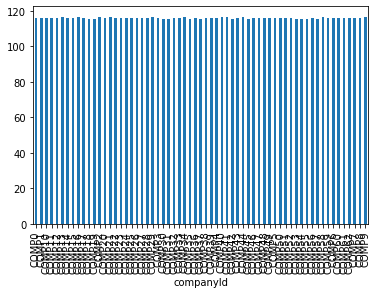

In [4]:
#checking if company ID has any quantitative value
full_data.reset_index(inplace=True,drop=True)
full_data.groupby(['companyId'])['salary'].mean().plot(kind ='bar');

companyId has 63 variables and each class has almost the equal mean.

there is no real value added to the model so we remove the column. 

In [5]:
full_data.drop('companyId',axis = 1,inplace=True)
unique_and_null_categorical(full_data)

JobId is Unique
Unique values in jobId: 999995 

jobType : 
 ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR'] 
 number of unique values: 8

degree : 
 ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE'] 
 number of unique values: 5

major : 
 ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING'] 
 number of unique values: 9

industry : 
 ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE'] 
 number of unique values: 7



### Splitting the data

In [6]:
x_train, x_val, y_train, y_val = train_test_split(full_data.drop(['salary'],axis = 1),full_data['salary'],test_size = 0.3, random_state= 157)

### Baseline model

In [7]:
x_train.set_index('jobId',inplace = True)
x_train_encoded = encode_and_bind(x_train)

In [8]:
model = LinearRegression()
scores = cross_val_score(model,x_train_encoded,y_train,scoring='neg_mean_squared_error')
print("%0.2f mse with a standard deviation of %0.2f for training data" % (abs(scores.mean()), scores.std()))

x_val.set_index('jobId',inplace = True)
x_val_encoded = encode_and_bind(x_val)

model.fit(x_train_encoded,y_train)
y_val_pred = model.predict(x_val_encoded)
print(mean_squared_error(y_val,y_val_pred),'for validation data')

384.36 mse with a standard deviation of 0.94 for training data
384.54462245126416 for validation data


***
**Baseline model gives us a MSE of 384 for both training and validation data**
***
To decrease the MSE further we select few models and try to tune them to achieve better MSE

SGDRegressor, Neural Networks, GBRegressor, Support Vector Regressor

https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/


* Encode categorical variables with ordinal and one hot encoding
* Apply PCA and check 
* feature scale numerical columns
* Include and remove numerical columns to check if it has an effect

Scaling and non-scaling

OneHotEncoding and Ordinal Coding

trying combination of features

PCA and No-PCA

1. Scale Data using scale_data - "only scales yearsExperience and milesFromMetropolis"
2. ordinal scale jobType and degree using ordinal scale
3. encode all variables with encode_and_bind

In [9]:
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    #using 5 fold CV and measuring with MSE 
    neg_mse = cross_val_score(model, feature_df, target_df, cv=5, n_jobs=num_procs, scoring='neg_mean_squared_error')
    #store the mean MSE of the model
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

In [10]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### 1) SVR

#### No Scaling

In [11]:
x_train_encoded = encode_and_bind(x_train)

In [12]:
kernels = ['rbf','sigmoid','linear','poly']

mse_kernel = []
for i in kernels: 
    svr = SVR(kernel=i,max_iter=500)
    svr.fit(x_train_encoded,y_train)
    y_pred = svr.predict(x_train_encoded)
    mse_kernel.append(mean_squared_error(y_train,y_pred))

In [13]:
mse_df = pd.DataFrame()
mse_kernel = pd.DataFrame(mse_kernel)
mse_df['kernel'] = kernels
mse_df['mse'] = mse_kernel

#### Scaling

In [14]:
x_train_sc,_ = scale_data(x_train)
x_train_sc_enc = encode_and_bind(x_train_sc)

In [15]:
mse_scaled =[]
for i in kernels: 
    svr = SVR(kernel=i,max_iter=500)
    svr.fit(x_train_sc_enc,y_train)
    y_pred = svr.predict(x_train_sc_enc)
    mse_scaled.append(mean_squared_error(y_train,y_pred))

In [16]:
mse_df['scaled_mse'] = pd.DataFrame(mse_scaled)

#### Ordinal Scaled

In [17]:
x_train_ord = ordinal_scale(x_train)
x_train_ord,_ = scale_data(x_train_ord)
x_train_ord_enc = encode_and_bind(x_train_ord)

In [18]:
mse_ord =[]
for i in kernels: 
    svr = SVR(kernel=i,max_iter=500)
    svr.fit(x_train_ord_enc,y_train)
    y_pred = svr.predict(x_train_ord_enc)
    mse_ord.append(mean_squared_error(y_train,y_pred))

mse_df['ordinal_mse'] = pd.DataFrame(mse_ord)

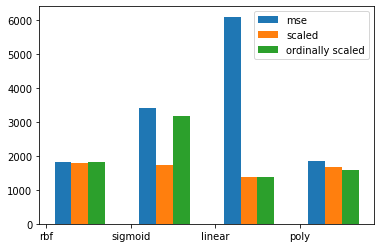

In [19]:
x_axis = np.arange(len(kernels))

# Multi bar Chart

plt.bar(x_axis +0.20, mse_df['mse'], width=0.2, label = 'mse')
plt.bar(x_axis +0.20*2, mse_df['scaled_mse'], width=0.2, label = 'scaled')
plt.bar(x_axis +0.20*3, mse_df['ordinal_mse'], width=0.2, label = 'ordinally scaled')
plt.xticks(x_axis,kernels)
plt.legend()

# Display

plt.show()

### 2) GBR

In [20]:
gbr = GradientBoostingRegressor(max_depth=7,alpha=0.1,verbose=1)
error = cross_val_score(gbr,x_train_encoded,y_train,cv =3, scoring='neg_mean_squared_error')

      Iter       Train Loss   Remaining Time 
         1        1330.0836            1.47m
         2        1190.4314            1.46m
         3        1074.8429            1.44m
         4         979.6346            1.43m
         5         899.2577            1.41m
         6         832.0884            1.39m
         7         773.4663            1.37m
         8         723.8668            1.36m
         9         681.8102            1.34m
        10         645.3304            1.33m
        20         450.8736            1.17m
        30         391.1700            1.02m
        40         369.5596           52.42s
        50         360.2584           43.49s
        60         355.7887           34.64s
        70         352.9547           25.85s
        80         351.2347           17.15s
        90         350.1152            8.54s
       100         349.1116            0.00s
      Iter       Train Loss   Remaining Time 
         1        1330.1313            1.45m
        

In [21]:
print('The mean RMSE and MSE of CV 3 is %f and %f respectively' %(abs(error.mean()),np.sqrt(abs(error.mean()))))

The mean RMSE and MSE of CV 3 is 357.429431 and 18.905804 respectively


<b>Hyperparameter tuning for GBR as it's MSE is better than SVR</b>

In [22]:
#initializing the parameters
param_test1 = {'n_estimators':range(20,101,10)}

#Tuning the hyperparameters
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=3, verbose=1)
gsearch1.fit(x_train_encoded,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(max_depth=8,
                                                 max_features='sqrt',
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 101, 10)},
             scoring='neg_mean_squared_error', verbose=1)

In [1]:
#printing out the results of the GridSearchCV
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

NameError: name 'gsearch1' is not defined

<b> Getting the n_estimator values and tuning the next two parameters max_depth and min_samples_split. </b> 

In [24]:
#initializing the parameters
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

#Tuning the hyperparameters
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,verbose=2, cv=3)
gsearch2.fit(x_train_encoded,y_train)

#Printing the results 
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


({'mean_fit_time': array([21.52927931, 22.27369396, 22.65266204, 22.30100004, 21.39967179,
         28.94397012, 28.77533237, 28.5246594 , 28.27000022, 28.00999363,
         34.58799879, 34.21266333, 34.27964481, 34.55900089, 34.15264161,
         40.01100421, 39.95399809, 39.58366577, 39.19532959, 38.85101891,
         44.37866926, 43.28529763, 42.83697414, 42.34363755, 41.64033135,
         47.79466303, 46.09500464, 45.70531956, 44.92800244, 35.18200191]),
  'std_fit_time': array([0.04493128, 0.53663867, 0.14950985, 0.09511187, 0.02107916,
         0.13283131, 0.08865798, 0.24176061, 0.02127202, 0.33278635,
         0.11011598, 0.11242629, 0.17201592, 0.30474522, 0.29854977,
         0.10255398, 0.18066991, 0.17513776, 0.03172086, 0.12300993,
         0.32819894, 0.17664094, 0.09700117, 0.14933873, 0.16722271,
         0.42291351, 0.11424782, 0.09960592, 0.12967398, 4.64784437]),
  'mean_score_time': array([0.70100745, 0.71330818, 0.71300117, 0.72766487, 0.71768634,
         0.830665

In [25]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}

gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4, cv=3)
gsearch3.fit(x_train_encoded,y_train)

gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([27.95832745, 27.8803122 , 27.94199022, 27.88599133, 27.62300372,
         27.64099622, 27.9769973 , 28.20931697, 27.78497465, 27.79899128,
         27.82999778, 27.73301959, 27.75000159, 27.89565802, 27.74666238,
         27.49665999, 27.56903243, 27.72299425, 27.72365578, 27.71100163,
         27.75999824, 27.57899936, 27.55932037, 27.40400243, 27.61267924,
         27.71965535, 27.6623288 , 27.7803367 , 27.5903128 , 20.93400073]),
  'std_fit_time': array([0.10485989, 0.11231038, 0.27132039, 0.13339425, 0.07478192,
         0.17924214, 0.14729271, 0.12151116, 0.0749454 , 0.19882925,
         0.12630699, 0.11060712, 0.15787971, 0.21820163, 0.16664322,
         0.19397331, 0.06965101, 0.21839432, 0.08226966, 0.0971714 ,
         0.09034561, 0.20157398, 0.09874407, 0.14074265, 0.10863883,
         0.12469734, 0.13256523, 0.21032647, 0.07243286, 4.63493916]),
  'mean_score_time': array([0.80133168, 0.81999985, 0.84000659, 0.84866206, 0.85100031,
         0.843999

In [26]:
param_test4 = {'max_features':range(7,20,2)}

gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11, min_samples_split=800, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4, cv=3,verbose=3)
gsearch4.fit(x_train_encoded,y_train)

gsearch4.cv_results_,gsearch4.best_params_,gsearch4.best_score_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


({'mean_fit_time': array([47.61096938, 56.70399618, 65.49766684, 74.40766184, 82.3706696 ,
         90.61564374, 82.62833548]),
  'std_fit_time': array([ 0.13626213,  0.05944522,  0.34824046,  0.25154006,  0.24819054,
          0.36250739, 13.50766054]),
  'mean_score_time': array([1.1186653 , 1.12735319, 1.08132895, 1.08366831, 1.11299276,
         1.07599751, 0.9309996 ]),
  'std_score_time': array([0.07383741, 0.03412964, 0.00981061, 0.02347356, 0.04439421,
         0.00216249, 0.0480478 ]),
  'param_max_features': masked_array(data=[7, 9, 11, 13, 15, 17, 19],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 7},
   {'max_features': 9},
   {'max_features': 11},
   {'max_features': 13},
   {'max_features': 15},
   {'max_features': 17},
   {'max_features': 19}],
  'split0_test_score': array([-358.58214853, -358.11369011, -357.77948066, -357.63106355,
         -357.7804679 , -357.59

<b> The Best parameters so far obtained are: 
1) min_samples_split = 800

2) min_samples_leaf = 60

3) max_depth = 11

4) max_features = 13

In [27]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11,min_samples_split=800, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=13),
param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4, cv=3,verbose=4)
gsearch5.fit(x_train_encoded,y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


({'mean_fit_time': array([62.22569497, 66.93234118, 69.28267169, 73.44666934, 77.94866808,
         64.48698235]),
  'std_fit_time': array([ 0.14478044,  2.53739215,  0.54710399,  0.24154987,  0.14142083,
         10.69023987]),
  'mean_score_time': array([1.13297407, 1.1126678 , 1.07199748, 1.09866873, 1.08500171,
         0.92400058]),
  'std_score_time': array([0.04278865, 0.03092378, 0.02298931, 0.00262692, 0.00777899,
         0.06047476]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([-357.83325123, -357.68915306, -357.73886256, -357.63106355,
         -357.7323972 , -357.63466448]),
  'split1_test_score': array([-357.38303289, -357.28080745, -357.18800619, -3

<b> Using the best hyperparameters and tune the learning rate and n_estimators

In [2]:
#learning rate with 0.05 with the best parameters
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=160,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
gbm_tuned_1.fit(x_train_encoded, y_train)

#Predict training set:
dtrain_predictions = gbm_tuned_1.predict(x_train_encoded)

#MSE for the training set
print(mean_squared_error(y_train,dtrain_predictions))

NameError: name 'GradientBoostingRegressor' is not defined

In [29]:
#learning rate with 0.05 and increasing n_estimators increased to 800
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=800,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
gbm_tuned_2.fit(x_train_encoded, y_train)

#Predict training set:
dtrain_predictions = gbm_tuned_2.predict(x_train_encoded)
#dtrain_predprob = gbm_tuned_1.predict_proba(x_train_encoded)[:,1]
print(mean_squared_error(y_train,dtrain_predictions))


335.4503335574303


In [30]:
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=800,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
error_1 = cross_val_score(gbm_tuned_3,x_train_encoded,y_train,cv =3, scoring='neg_mean_squared_error')

In [31]:
gbm_tuned_4 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=160,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
error_2 = cross_val_score(gbm_tuned_4,x_train_encoded,y_train,cv =3, scoring='neg_mean_squared_error')

<b> Higher number of n_estimators overfits the model 

In [32]:
print(error_1.mean(),error_2.mean())

-360.62520018141777 -356.82856983346187


In [33]:
gbm4_pred = gbm_tuned_1.predict(x_val_encoded)
print(mean_squared_error(y_val,gbm4_pred))

356.8859952136066


### Deep Neural Networks 

In [34]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout

### No dropouts

In [35]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train_encoded.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4096      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 168,961
Trainable params: 168,961
Non-trainable params: 0
_________________________________________________________________


In [36]:
NN_model.fit(x_train_encoded, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
17500/17500 [==============================] - 37s 2ms/step - loss: 16.3513 - mse: 426.9840 - val_loss: 16.7250 - val_mse: 445.9255
Epoch 2/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.7546 - mse: 381.9223 - val_loss: 16.0920 - val_mse: 393.9872
Epoch 3/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.6748 - mse: 377.1689 - val_loss: 15.6669 - val_mse: 381.3178
Epoch 4/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.5821 - mse: 371.1630 - val_loss: 15.5123 - val_mse: 364.5983
Epoch 5/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.5365 - mse: 368.7537 - val_loss: 15.4465 - val_mse: 361.8874
Epoch 6/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.5192 - mse: 367.7304 - val_loss: 15.4445 - val_mse: 363.0990
Epoch 7/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.5007 - mse: 366.7715 - val_loss: 15.5483 - val_mse: 365.4628

In [37]:
predictions = NN_model.predict(x_val_encoded)
print(mean_squared_error(y_val,predictions))

360.7175204036213


#### activation layer ReLu, with less hidden layers and nodes 

In [ ]:
NN_model_2 = Sequential()

# The Input Layer :
NN_model_2.add(Dense(64, kernel_initializer='normal',input_dim = x_train_encoded.shape[1], activation='selu'))

# The Hidden Layers :
NN_model_2.add(Dense(128, kernel_initializer='normal',activation='selu'))
NN_model_2.add(Dense(128, kernel_initializer='normal',activation='selu'))

# The Output Layer :
NN_model_2.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
NN_model_2.summary()

In [ ]:
NN_model_2.fit(x_train_encoded, y_train, epochs=20, batch_size=32, validation_split = 0.2)

In [ ]:
predictions_2 = NN_model_2.predict(x_val_encoded)
print(mean_squared_error(y_val,predictions_2))

### with dropouts

In [ ]:
NN_model_3 = Sequential()

# The Input Layer :
NN_model_3.add(Dense(64, kernel_initializer='normal',input_dim = x_train_encoded.shape[1], activation='selu'))
NN_model_3.add(Dropout(0.2))
# The Hidden Layers :
NN_model_3.add(Dense(128, kernel_initializer='normal',activation='selu'))
NN_model_3.add(Dropout(0.2))
NN_model_3.add(Dense(128, kernel_initializer='normal',activation='selu'))
NN_model_3.add(Dropout(0.2))
# The Output Layer :
NN_model_3.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model_3.compile(loss='mean_absolute_error', optimizer='adamax', metrics=['mse'])
NN_model_3.summary()


In [ ]:
NN_model_3.fit(x_train_encoded, y_train, epochs=20, batch_size=32, validation_split = 0.2)

In [ ]:
predictions_3 = NN_model_3.predict(x_val_encoded)
print(mean_squared_error(y_val,predictions_3))